<h1> Multicomponent gas absorption </h1>

<img src="https://5.imimg.com/data5/AJ/YS/MY-3493775/scrubber-column-500x500.jpg" /> 

<h2> What exactly are we doing? </h2>
We are solving for the initial value problem
There is a gas mixture consists of <b><i>"Acetaldehyde"</i></b> & <b><i>"Acetone"</i></b>.The mixture is scrubbed using pure water. (Heat balances are ignored). Pure water comes from the top & gases come from bottom. No reaction is taking place.  

<h3> Formulae used </h3>
$$
    \frac{dy}{dz} = \frac{S.k_{Ga}}{G_{s}}_*\frac{(1-y)_{iLm}}{(1-y)*(y-y_{i})}
$$

$$
    \frac{dx}{dz} = \frac{S.k_{La}}{L_{s}}_*\frac{(1-x)_{iLm}}{(1-x)*(x-x_{i})}
$$


$$
    xi=\frac{(y+\frac{k_{La}}{k_{Ga}})}{1}_*\frac{1}{(x+\frac{k_{La}}{k_{Ga}})}
$$

<h2> How are we solving? </h2>
We are solving for the initial value boundary residuals. Residual goes to zero.

In [1]:
import scipy
import scipy.integrate as scint
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import derivative

In [2]:
Ls=200 #molar water flow rate
Gi=150 #molar gas flow rate input
D=0.5
y1i=0.05 #mole fractions
y2i=0.05 #mole fractions
Gs=(1-y1i-y2i)*Gi
M=Gs/Gi*28.81+y1i*30+y2i*28
Qg=Gi*M*1e-3/1.225
S=scipy.pi*0.25*D**2
ug=Qg/S
kLa=0.0269*ug**0.82
kGa=0.0005
H1=40.54
H2=20.13
H=3


In [3]:
#finding x1i
def findx1i(x1,y1,x1i):
    x1i=(y1+kLa/kGa*x1)/(kLa/kGa+H1)
    return x1i

In [4]:
#finding x2i
def findx2i(x2,y2,x2i):
    x2i=(y2+kLa/kGa*x2)/(kLa/kGa+H2)
    return x2i

In [5]:
def model(SV,z,obj):
    [x1,x2,y1,y2]=SV
    D=obj.D
    S=obj.S
    Ls=obj.Ls
    H1=obj.H1
    H2=obj.H2
    H=obj.H
    x1i=0.005
    x2i=0.005
    dx1bydz=kLa*S/Ls*(1-x1)**2*scipy.log((1-x1)/(1-findx1i(x1,y1,x1i)))
    dx2bydz=kLa*S/Ls*(1-x2)**2*scipy.log((1-x2)/(1-findx2i(x2,y2,x2i)))
    dy1bydz=-kGa*S/Gs*(1-y1)**2*scipy.log((1-y1)/(1-H1*x1i))
    dy2bydz=-kGa*S/Gs*(1-y2)**2*scipy.log((1-y2)/(1-H2*x2i))
    return [dx1bydz,dx2bydz,dy1bydz,dy2bydz]

            
        
    

In [6]:
def get_boundary_residuals(SV0, obj):
    z = scipy.array([0, obj.H])
    trial_solution = scint.odeint(model, SV0, z, args = (obj,))
    SVi = trial_solution[0]
    SVb = trial_solution[-1]
    error = []
    k = 0
    for ic in obj.initial_conditions:
        error.append(ic - SVi[k])
        k += 1
    for bc in obj.boundary_conditions:
        error.append(bc - SVb[k])
        k += 1
    return error

In [7]:
class absorption:
    def __init__(self):
        self.D=0.5
        self.S=scipy.pi*0.25*D**2
        self.Ls=250
        self.H1=299
        self.H2=354
        self.H=3
        self.y1in=0.04
        self.y2in=0.04
        self.x1in=0
        self.x2in=0
    def solve(self):
        self.x=scipy.linspace(0,self.H,10)
        self.initial_conditions=[self.y1in,self.y2in]
        self.boundary_conditions=[self.x1in,self.x2in]
        SV0=self.initial_conditions + self.boundary_conditions
        shooting_method_solution = scopt.least_squares(get_boundary_residuals,
                                                      SV0,
                                                      args = (self,))
        SV0=shooting_method_solution.x
        solution = scint.odeint(model, SV0, self.x, args = (self,))
        self.solution=pd.DataFrame({
            "x":self.x,
            "x1":solution[:,0],
            "x2":solution[:,1],
            "y1":solution[:,2],
            "y2":solution[:,3],
            
        }
        
        )
    def plotx(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.solution["x"], 
                self.solution["x1"],
                'c', label = "Acetaldehyde")
        ax.plot(self.solution["x"],
               self.solution["x2"],
               'g', label="Acetone")
        ax.legend()
        ax.xaxis.label.set_text("Height in m")
        ax.yaxis.label.set_text("mole fraction in gas")
        ax.title.set_text("Concentration Profiles")
    def ploty(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.solution["x"], 
                self.solution["y1"],
                'c', label = "Acetaldehyde")
        ax.plot(self.solution["x"],
               self.solution["y2"],
               'g', label="Acetone")
        ax.legend()
        ax.xaxis.label.set_text("Height in m")
        ax.yaxis.label.set_text("mole fraction in liquid")
        ax.title.set_text("Concentration Profiles")

In [8]:
cchex1 = absorption()
cchex1.H = 5

In [12]:
cchex1.solve()

In [10]:
cchex1.solution

,x,x1,x2,y1,y2
0,0.000000,0.040000,0.040000,2.556887e-06,9.503465e-07
1,0.555556,0.040000,0.040000,2.272789e-06,8.447526e-07
2,1.111111,0.039999,0.040000,1.988692e-06,7.391587e-07
3,1.666667,0.039999,0.040000,1.704593e-06,6.335648e-07
4,2.222222,0.039999,0.039999,1.420495e-06,5.279708e-07
5,2.777778,0.039998,0.039999,1.136397e-06,4.223768e-07
6,3.333333,0.039998,0.039999,8.522978e-07,3.167826e-07
7,3.888889,0.039998,0.039999,5.681987e-07,2.111885e-07
8,4.444444,0.039997,0.039999,2.840993e-07,1.055942e-07
9,5.000000,0.039997,0.039999,-4.116221e-13,-9.680519e-14


(None, None)

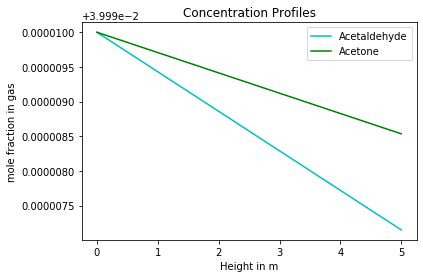

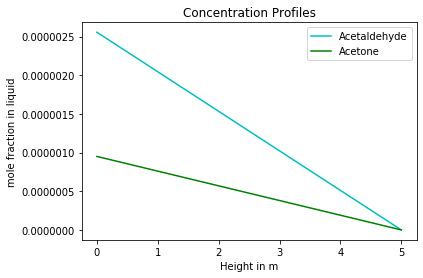

In [11]:
cchex1.plotx(),cchex1.ploty()